Python Version: 3.12.4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
! git clone https://github.com/phipyao/ds4002-project-2

Cloning into 'ds4002-project-2'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 126 (delta 51), reused 57 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (126/126), 3.43 MiB | 10.54 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [67]:
df = pd.read_csv("/content/ds4002-project-2/DATA/cville monthly precip total v2.csv")
df.head()

,Year,January,February,March,April,May,June,July,August,September,October,November,December,Annual
0,1893,M,M,M,3.54,M,M,M,M,M,M,M,M,M
1,1894,M,M,M,M,M,M,M,M,M,M,M,M,M
2,1895,M,M,M,M,M,M,M,M,M,M,M,M,M
3,1896,M,M,M,M,M,M,M,M,M,0.25,M,T,M
4,1897,M,M,M,M,M,M,M,M,M,M,M,M,M


In [68]:
# Replacing "M" and "T" values with null values
df.replace('M', pd.NA, inplace=True)
df.replace('T', pd.NA, inplace=True)

# Drop annual precipitation
if 'Annual' in df.columns:
    df = df.drop(columns=['Annual'])

# Convert the data to numeric (ignores non-numeric values like NaN)
for month in df.columns[1:]:  # Skip the 'Year' column
    df[month] = pd.to_numeric(df[month], errors='coerce')

df.head()



# Impute missing values
df = df.fillna(method='ffill')
df = df.dropna()

df = pd.melt(df, id_vars=['Year'],
                  var_name='Month',
                  value_name='Value')


# Map the abbreviated month names to numbers (Jan -> 01, Feb -> 02, etc.)
month_map = {'January': '01',
             'February': '02',
             'March': '03',
             'April': '04',
             'May': '05',
             'June': '06',
             'July': '07',
             'August': '08',
             'September': '09',
             'October': '10',
             'November': '11',
             'December': '12'}

# Convert Month abbreviations to numbers and create a Date column
df['Month'] = df['Month'].map(month_map)
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'], format='%Y%m')


df = df.sort_values("Date")

df.drop(['Month',"Year"], axis=1, inplace=True)
df.set_index('Date', inplace=True)

df.head()

# df = df.set_index('Date', inplace=True)

# df = pd.melt(df, id_vars=['Year'], value_vars=['January','February','March','April','May','June','July','August','September','October','November','December'])

# df['Date'] = pd.to_datetime(df['Year'].astype(str) + ' ' + df['variable'])

# # Set the 'Date' column as the index
# df.set_index('Date', inplace=True)

# # Drop the 'Year' and 'variable' columns if needed
# df.drop(['Year', 'variable'], axis=1, inplace=True)



<ipython-input-68-21702f23854b>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Value
Date,
1901-01-01,4.46
1901-02-01,0.90
1901-03-01,2.45
1901-04-01,9.05
1901-05-01,7.66


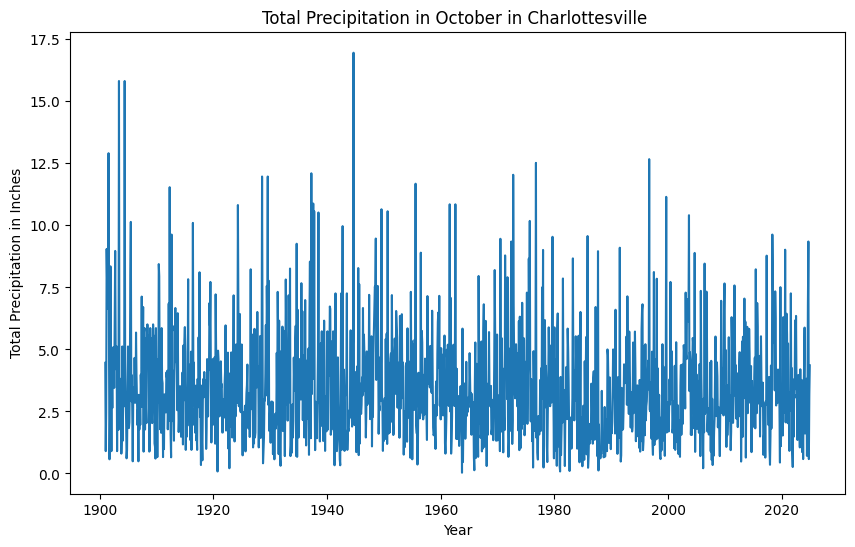

In [71]:
# Plotting time series
plt.figure(figsize=(10,6))

plt.plot(df.index, df['Value'])
plt.title('Total Precipitation by month from 1901 in Charlottesville ')
plt.ylabel('Total Precipitation in Inches')
plt.xlabel('Year')
plt.show()

In [53]:
# Check for stationarity using the Augmented Dickey-Fuller test

result = adfuller(df['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -9.665855477306511
p-value: 1.315872598001261e-16


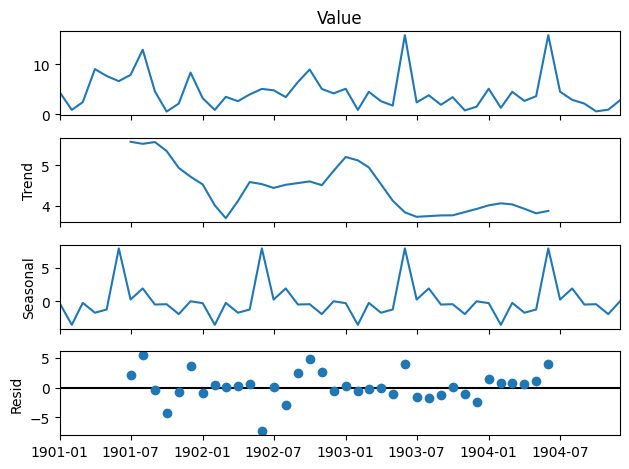

In [52]:
# Seasonality checker

result = seasonal_decompose(df['Value'][:48], model='additive')
result.plot()
plt.show()

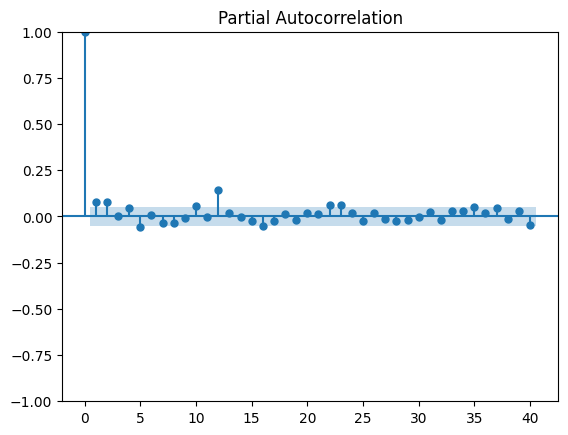

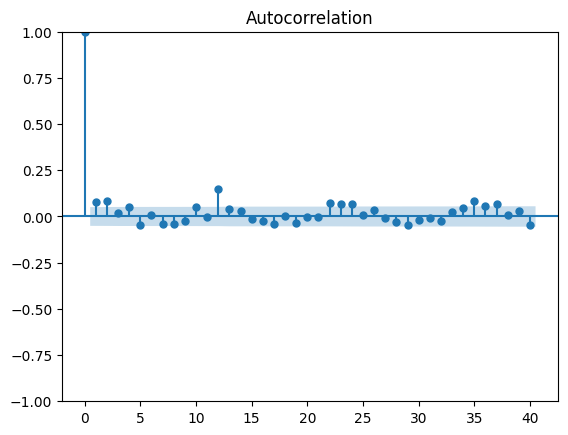

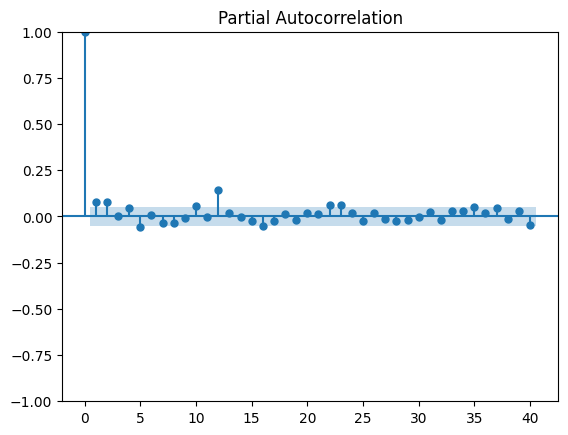

In [47]:
# ACF and PACF plots for Parameter values

plot_acf(df['Value'], lags=40)
plot_pacf(df['Value'], lags=40)

In [54]:
# Apply SARIMA Model
model = SARIMAX(df['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit()

# Summary of the model
print(sarima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                 1488
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3245.247
Date:                            Thu, 24 Oct 2024   AIC                           6500.494
Time:                                    02:22:32   BIC                           6526.976
Sample:                                01-01-1901   HQIC                          6510.367
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0277      0.027      1.014      0.310      -0.026       0.081
ma.L1         -0.9892      0.005   

In [55]:
# Apply SARIMA Model
model2 = SARIMAX(df['Value'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_fit2 = model2.fit()

# Summary of the model
print(sarima_fit2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                 1488
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -3261.497
Date:                            Thu, 24 Oct 2024   AIC                           6532.993
Time:                                    02:25:05   BIC                           6559.519
Sample:                                01-01-1901   HQIC                          6542.879
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9980      0.001    895.661      0.000       0.996       1.000
ma.L1         -0.9781      0.007   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


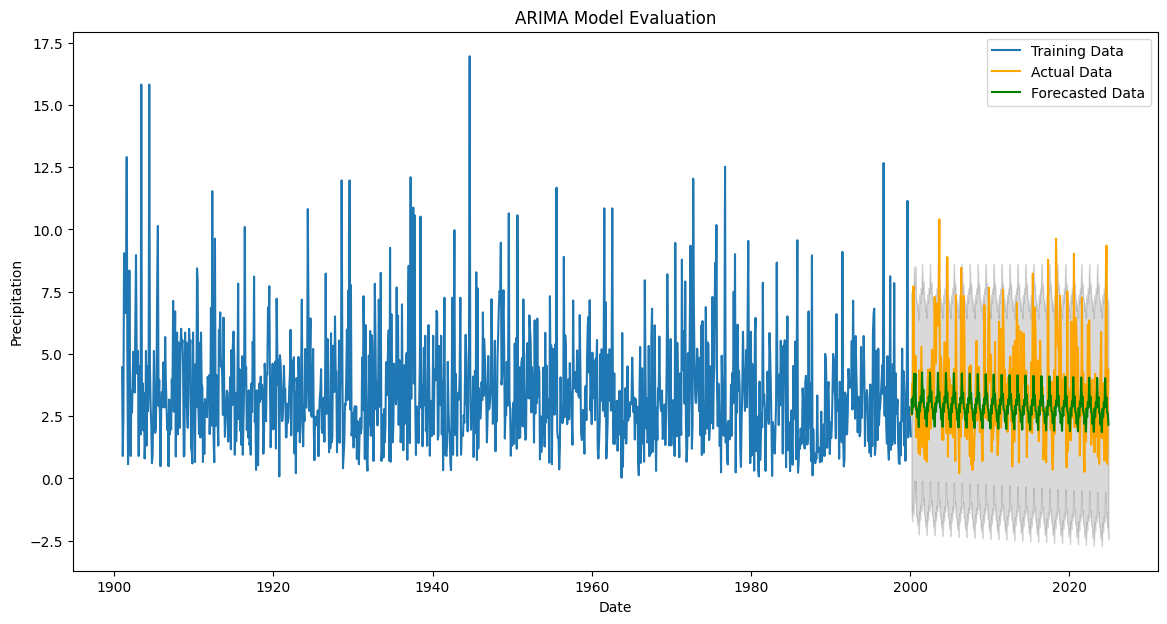

MAPE: 0.6975926981090768


In [59]:
# Split the data into train and test
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# Fit the ARIMA model on the training dataset
model_train = SARIMAX(train['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)


# Calculate the mean absolute error
mape = mean_absolute_percentage_error(test['Value'], test_forecast_series)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['Value'], label='Training Data')
plt.plot(test['Value'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

print('MAPE:', mape)

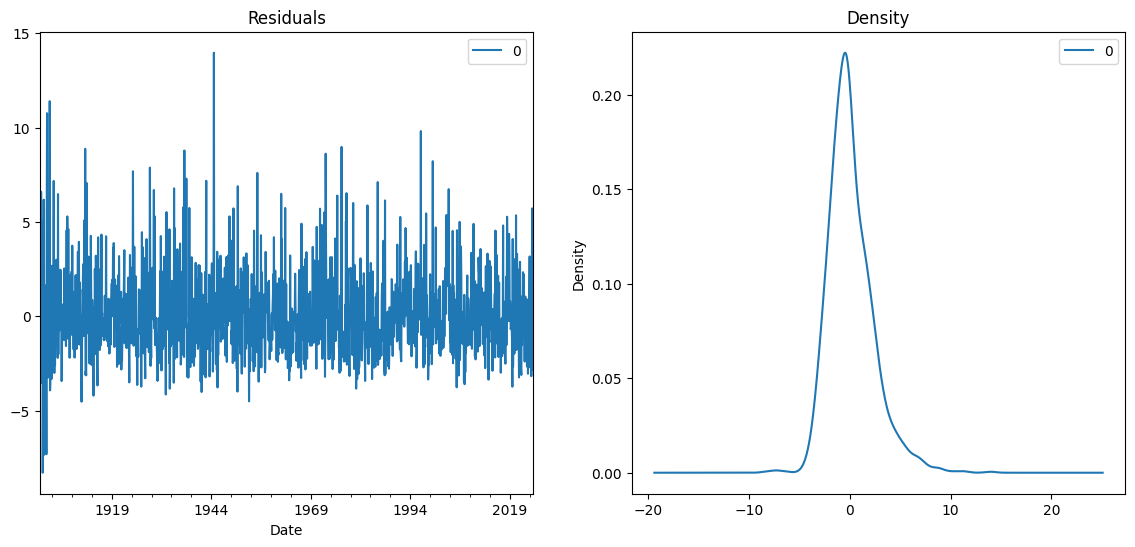

In [61]:
# Resdiual Analysis

residuals = pd.DataFrame(sarima_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

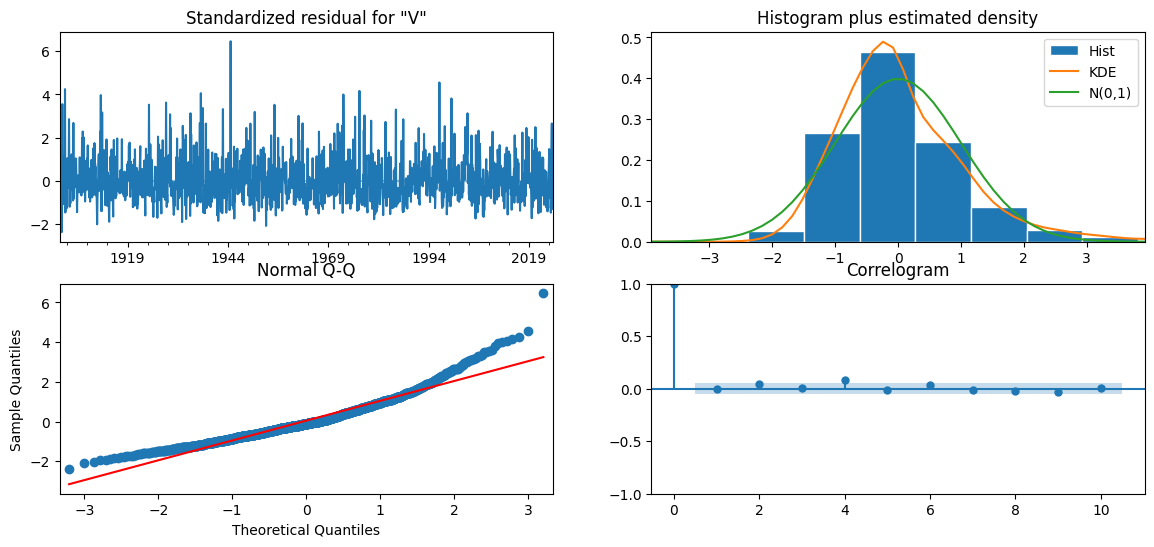

In [62]:
# Futher residual analysis

sarima_fit.plot_diagnostics(figsize=(14, 6))
plt.show()

<ipython-input-63-2933842c865a>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


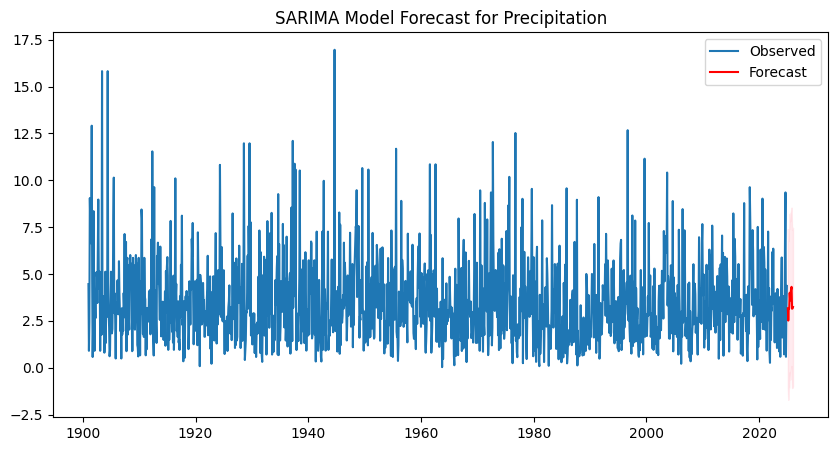

In [63]:
# Forecast the next 12 months
forecast = sarima_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(df, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Model Forecast for Precipitation")
plt.legend()
plt.show()

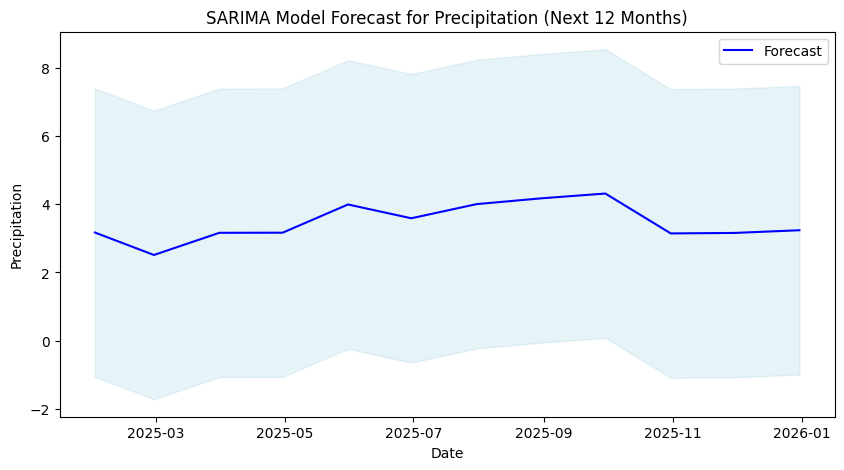

In [64]:
# Plot only the forecast
plt.figure(figsize=(10, 5))
plt.plot(forecast_index, forecast_values, label='Forecast', color='blue')

# Optionally, you can fill the confidence intervals for a clearer visualization
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='lightblue', alpha=0.3)

# Customize the plot
plt.title("SARIMA Model Forecast for Precipitation (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()